In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
# Local paths for dataset and annotations
dataset_path = '/content/drive/MyDrive/dataset2/dataset/dataset/examples'
label_path = '/content/drive/MyDrive/dataset2/dataset/dataset/labels_dict.json'
annotation_path = '/content/drive/MyDrive/dataset2/dataset/dataset/annotation_dict.json'


In [ ]:
# Load label and annotation dictionaries
with open(label_path, 'r') as f:
    label_dict = json.load(f)

# Use annotation_path directly without appending 'annotation_dict.json'
with open(annotation_path, 'r') as f:
    annotation_dict = json.load(f)

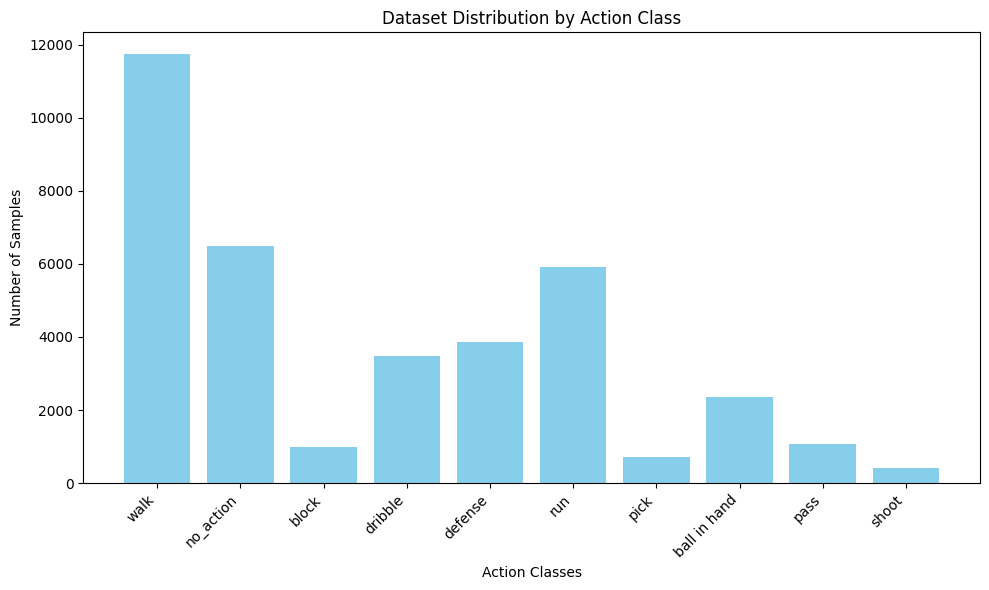

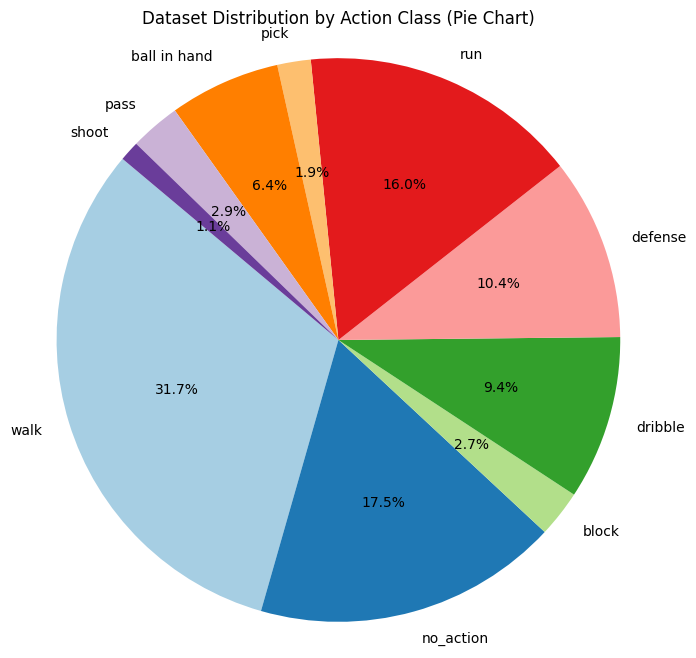

In [ ]:
# Count the distribution of action classes in the dataset
action_counts = {}
for video_name, label in annotation_dict.items():
    action_name = label_dict[str(label)]  # Convert label number to action name
    if action_name not in action_counts:
        action_counts[action_name] = 0
    action_counts[action_name] += 1

# Sort the counts for better visualization
action_names = list(action_counts.keys())
action_values = list(action_counts.values())

# Plot the distribution using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(action_names, action_values, color='skyblue')
plt.xlabel('Action Classes')
plt.ylabel('Number of Samples')
plt.title('Dataset Distribution by Action Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Optionally, plot a pie chart for distribution
plt.figure(figsize=(8, 8))
plt.pie(action_values, labels=action_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Dataset Distribution by Action Class (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

In [ ]:
# Dataset parameters
IMG_SIZE = 32  # Resize frames to 64x64
FRAMES_COUNT = 16  # Number of frames per video
NUM_CLASSES = len(label_dict)

# Function to load a video and extract frames
def load_video(video_path, frame_count=FRAMES_COUNT):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < frame_count:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame)
    cap.release()
    while len(frames) < frame_count:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))
    return np.array(frames)

In [ ]:
# Process training videos and labels
train_videos, train_labels = [], []
for video_name, label in tqdm(annotation_dict.items(), desc="Processing train videos", unit="video"):
    video_path = os.path.join(dataset_path, 'train', f"{video_name}.mp4")
    if os.path.exists(video_path):
        train_videos.append(load_video(video_path))
        train_labels.append(label)

Processing train videos: 100%|██████████| 37085/37085 [00:20<00:00, 1775.99video/s]


In [ ]:
train_labels[5], len (train_videos), len(train_videos[0])

(3, 1072, 16)

In [ ]:
# Process testing videos and labels
test_videos, test_labels = [], []
for video_name, label in tqdm(annotation_dict.items(), desc="Processing test videos", unit="video"):
    video_path = os.path.join(dataset_path, 'test', f"{video_name}.mp4")
    if os.path.exists(video_path):
        test_videos.append(load_video(video_path))
        test_labels.append(label)

Processing test videos: 100%|██████████| 37085/37085 [00:09<00:00, 3987.69video/s]


In [ ]:
test_labels[2], len (test_videos), len(test_videos[0])

(3, 281, 16)

In [ ]:
# Convert data to numpy arrays and normalize
train_videos = np.array(train_videos) / 255.0
test_videos = np.array(test_videos) / 255.0


In [ ]:
# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, NUM_CLASSES)
test_labels = to_categorical(test_labels, NUM_CLASSES)

In [ ]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_videos, train_labels, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment video data
def augment_videos(videos, datagen):
    augmented_videos = []
    for video in videos:
        augmented_video = []
        for frame in video:
            frame = frame.reshape((1, *frame.shape))  # Reshape frame to 4D
            augmented_frame = datagen.random_transform(frame[0])  # Apply augmentation
            augmented_video.append(augmented_frame)
        augmented_videos.append(np.array(augmented_video))
    return np.array(augmented_videos)

# Apply data augmentation to training videos
X_train_augmented = augment_videos(X_train, datagen)

# Combine original and augmented data (optional)
X_train_combined = np.concatenate((X_train, X_train_augmented), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)  # Duplicate labels for augmented data


In [ ]:
# Create the model with regularization and dropout
def create_model(input_shape=(FRAMES_COUNT, IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=input_shape),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
# Compile the model
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.3079 - loss: 3.2333 - val_accuracy: 0.3628 - val_loss: 2.0371
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3461 - loss: 2.0341 - val_accuracy: 0.3628 - val_loss: 1.9408
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3516 - loss: 1.9755 - val_accuracy: 0.3628 - val_loss: 1.8959
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3205 - loss: 1.9312 - val_accuracy: 0.3628 - val_loss: 1.8951
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3503 - loss: 1.9099 - val_accuracy: 0.3628 - val_loss: 1.8621
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3610 - loss: 1.8709 - val_accuracy: 0.3953 - val_loss: 1.8394
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3608 - loss: 1.8444 - val_accuracy: 0.3860 - val_loss: 1.8759
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3688 - loss: 1.8829 - val_accuracy: 0

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_videos, test_labels, batch_size=16)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3849 - loss: 1.8170
Test Loss: 1.8212436437606812
Test Accuracy: 0.3701067566871643


In [ ]:
# Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

In [ ]:
# Calculate per-class accuracy
y_pred = model.predict(test_videos, batch_size=16)

# Convert one-hot encoded predictions and labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Initialize a dictionary to store per-class accuracy
per_class_accuracy = {}

# Calculate accuracy for each class
for class_idx, class_name in label_dict.items():
    class_idx = int(class_idx)  # Ensure class index is an integer
    # Get indices for the current class
    class_indices = np.where(y_true_classes == class_idx)[0]
    # Calculate the number of correct predictions for this class
    correct_predictions = np.sum(y_pred_classes[class_indices] == class_idx)
    # Calculate accuracy for this class
    class_accuracy = correct_predictions / len(class_indices)
    # Store the accuracy
    per_class_accuracy[class_name] = class_accuracy

# Print per-class accuracy
for class_name, accuracy in per_class_accuracy.items():
    print(f"Accuracy for {class_name}: {accuracy:.2f}")

# Plot the per-class accuracy distribution as a bar chart
import matplotlib.pyplot as plt

class_names = list(per_class_accuracy.keys())
accuracies = list(per_class_accuracy.values())

plt.figure(figsize=(10, 6))
plt.bar(class_names, accuracies, color='skyblue')
plt.xlabel('Action Classes')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy Distribution')
plt.ylim(0, 1)  # Accuracy range is from 0 to 1
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


SyntaxError: '[31m[1mbatch_size[0m' is not a valid YOLO argument. Similar arguments are i.e. ['batch=8'].

    Arguments received: ['yolo', '-f', '/root/.local/share/jupyter/runtime/kernel-d6ce4ff9-811d-4357-8288-ca807db10069.json']. Ultralytics 'yolo' commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of {'detect', 'obb', 'pose', 'segment', 'classify'}
                MODE (required) is one of {'export', 'benchmark', 'predict', 'train', 'track', 'val'}
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/usage/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo train data=coco8.yaml model=yolo11n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at image size 320:
        yolo predict model=yolo11n-seg.pt source='https://youtu.be/LNwODJXcvt4' imgsz=320

    3. Val a pretrained detection model at batch-size 1 and image size 640:
        yolo val model=yolo11n.pt data=coco8.yaml batch=1 imgsz=640

    4. Export a YOLO11n classification model to ONNX format at image size 224 by 128 (no TASK required)
        yolo export model=yolo11n-cls.pt format=onnx imgsz=224,128

    5. Ultralytics solutions usage
        yolo solutions count or in ['heatmap', 'queue', 'speed', 'workout', 'analytics', 'trackzone', 'inference'] source="path/to/video/file.mp4"

    6. Run special commands:
        yolo help
        yolo checks
        yolo version
        yolo settings
        yolo copy-cfg
        yolo cfg
        yolo solutions help

    Docs: https://docs.ultralytics.com
    Solutions: https://docs.ultralytics.com/solutions/
    Community: https://community.ultralytics.com
    GitHub: https://github.com/ultralytics/ultralytics
     (<string>)

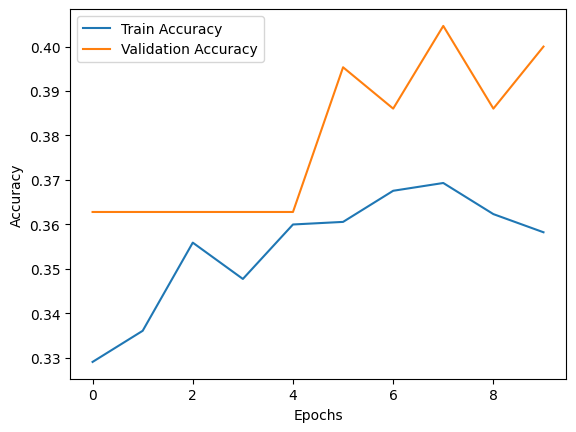

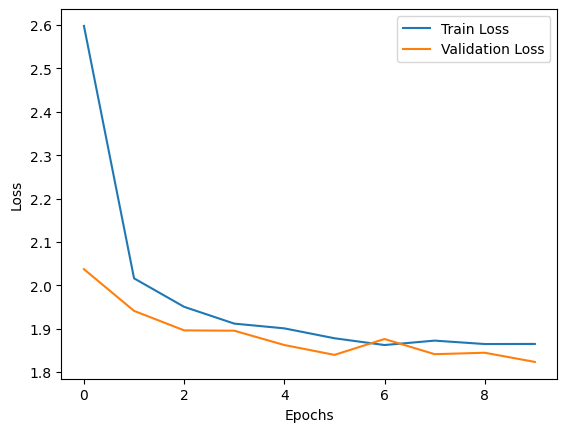

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on the test set
y_pred = model.predict(test_videos)

# Get the predicted class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Confusion Matrix:
[[ 0  0  0  0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0  1  0  0  8]
 [ 0  0  0  0  0  0  5  0  0 25]
 [ 0  0  0  0  0  0 14  0  0 22]
 [ 0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  4  0  0 14]
 [ 0  0  0  0  0  0 17  0  0 20]
 [ 0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  2  0  0 44]
 [ 0  0  0  0  0  0  5  0  0 87]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        18
           6       0.35      0.46      0.40        37
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        46
           9       0.37      0.95      0.54      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def predict_on_video(video_name, dataset_path, model):
    # Path to the video file
    video_path = os.path.join(dataset_path, 'test', f"{video_name}.mp4")

    # Check if the video exists
    if not os.path.exists(video_path):
        print(f"Video {video_name} does not exist in the test dataset.")
        return

    # Load the video
    video_data = load_video(video_path)  # Use the load_video function defined earlier
    video_data = np.expand_dims(video_data / 255.0, axis=0)  # Normalize and add batch dimension

    # Predict the class
    predicted_probabilities = model.predict(video_data)
    predicted_class = np.argmax(predicted_probabilities)

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

# Predict on the video with name "0037470"
video_name = '0037089'  # Video name without .mp4 extension
predicted_class = predict_on_video(video_name, dataset_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Predicted Class: 6


In [ ]:
# Predict on a sample video
sample_video = test_videos[0]  # Choose a sample video
sample_label = np.argmax(test_labels[0])  # True label for the sample

# Reshape sample for prediction
sample_video = np.expand_dims(sample_video, axis=0)  # Add batch dimension

# Predict class
predicted_probabilities = model.predict(sample_video)
predicted_class = np.argmax(predicted_probabilities)

print(f"True Label: {sample_label}, Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
True Label: 3, Predicted Class: 9


In [ ]:
print("Label Dictionary:", label_dict)

Label Dictionary: {'0': 'block', '1': 'pass', '2': 'run', '3': 'dribble', '4': 'shoot', '5': 'ball in hand', '6': 'defense', '7': 'pick', '8': 'no_action', '9': 'walk', '10': 'discard'}


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Reshape, TimeDistributed, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Create the model with LSTM
def create_model(input_shape=(FRAMES_COUNT, IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    model = Sequential([
        # TimeDistributed wrapper allows applying Conv2D to each frame independently
        TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)), input_shape=input_shape),
        TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
        TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01))),
        TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
        TimeDistributed(Flatten()),  # Flatten each frame's feature map
        LSTM(128, return_sequences=False),  # LSTM layer to capture temporal dependencies
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model



In [ ]:
# Compile the model
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 16, 30, 30, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 15, 15, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 16, 13, 13, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 16, 6, 6, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 16, 2304)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       1,245,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,019 (4.89 MB)

 Trainable params: 1,283,019 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:

# Train the model
history = model.fit(
    X_train_combined, y_train_combined,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.2841 - loss: 3.1701 - val_accuracy: 0.3628 - val_loss: 2.2004
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3376 - loss: 2.1356 - val_accuracy: 0.3628 - val_loss: 2.0246
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3859 - loss: 1.9416 - val_accuracy: 0.3535 - val_loss: 1.9329
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3492 - loss: 1.9098 - val_accuracy: 0.3907 - val_loss: 1.9021
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3757 - loss: 1.8699 - val_accuracy: 0.4093 - val_loss: 1.8697
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.3836 - loss: 1.8380 - val_accuracy: 0.4000 - val_loss: 1.8566
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3676 - loss: 1.8160 - val_accuracy: 0.4000 - val_loss: 1.8450
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3725 - loss: 1.8462 - val_acc

In [ ]:
!pip install ultralytics


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO


In [ ]:
# Paths
video_path = "/content/1090384895-preview.mp4"
model_path = "/content/yolov8n.pt"
output_dir = "/content/drive/MyDrive/cropped_players"

# Create output directory
os.makedirs(output_dir, exist_ok=True)


In [ ]:
# Load the YOLO model
model = YOLO(model_path)


In [ ]:
def detect_and_crop(video_path, output_dir, frame_count=16):
    # Capture video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return None

    frame_paths = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret or frame_idx >= frame_count:
            break

        # YOLO prediction on the current frame
        results = model.predict(source=frame, imgsz=640, conf=0.5)
        detections = results[0].boxes.xyxy.cpu().numpy()  # Extract bounding boxes

        for idx, bbox in enumerate(detections):
            x1, y1, x2, y2 = map(int, bbox[:4])
            cropped_frame = frame[y1:y2, x1:x2]  # Crop player

            # Resize the cropped frame
            cropped_frame = cv2.resize(cropped_frame, (224, 224))

            # Save the cropped frame as an image
            frame_name = f"frame_{frame_idx}_player_{idx}.jpg"
            frame_path = os.path.join(output_dir, frame_name)
            cv2.imwrite(frame_path, cropped_frame)
            frame_paths.append(frame_path)

        frame_idx += 1

    cap.release()
    return frame_paths


In [ ]:
frame_paths = detect_and_crop(video_path, output_dir, frame_count=16)
if not frame_paths:
    print("No frames were processed.")



0: 384x640 2 persons, 1 sports ball, 57.4ms
Speed: 2.1ms preprocess, 57.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 sports ball, 7.3ms
Speed: 3.4ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 sports ball, 7.3ms
Speed: 3.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8.1ms
Speed: 3.4ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 13.8ms
Speed: 3.3ms preprocess, 13.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 8.8ms
Speed: 3.1ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 27.8ms
Speed: 3.9ms preprocess, 27.8ms inference, 2.5

In [ ]:
# Sample label dictionary for predictions
label_dict = {"0": "block","1": "pass","2": "run","3": "dribble","4": "shoot","5": "ball in hand","6": "defense","7": "pick","8": "no_action","9": "walk","10": "discard"}

# Predict actions on the cropped frames
predictions = model.predict(source=frame_paths, imgsz=640, batch=8)

# Process predictions
for i, result in enumerate(predictions):
    if result.boxes:
        predicted_class = np.argmax(result.probs)
        print(f"Player {i} action: {label_dict[str(predicted_class)]}")
    else:
        print(f"Player {i} action: No detection.")



0: 640x640 (no detections), 5.0ms
1: 640x640 1 person, 1 horse, 5.0ms
2: 640x640 1 person, 5.0ms
3: 640x640 1 person, 1 horse, 5.0ms
4: 640x640 1 person, 5.0ms
5: 640x640 (no detections), 5.0ms
6: 640x640 1 person, 1 horse, 5.0ms
7: 640x640 1 person, 5.0ms
8: 640x640 (no detections), 5.0ms
9: 640x640 1 horse, 5.0ms
10: 640x640 1 person, 5.0ms
11: 640x640 1 person, 1 horse, 5.0ms
12: 640x640 1 person, 5.0ms
13: 640x640 2 persons, 5.0ms
14: 640x640 1 person, 1 horse, 5.0ms
15: 640x640 1 person, 1 horse, 5.0ms
16: 640x640 1 person, 5.0ms
17: 640x640 1 person, 5.0ms
18: 640x640 1 person, 5.0ms
19: 640x640 1 person, 5.0ms
20: 640x640 1 person, 5.0ms
21: 640x640 1 person, 5.0ms
22: 640x640 2 persons, 5.0ms
23: 640x640 (no detections), 5.0ms
24: 640x640 2 persons, 5.0ms
25: 640x640 1 horse, 5.0ms
26: 640x640 2 persons, 5.0ms
27: 640x640 1 person, 5.0ms
28: 640x640 3 persons, 5.0ms
29: 640x640 1 person, 1 horse, 5.0ms
30: 640x640 2 persons, 5.0ms
31: 640x640 1 person, 1 horse, 5.0ms
32: 640x6